<a href="https://colab.research.google.com/github/yongchuu/TensorflowTeam5/blob/main/tensorflow_final_exam(2021_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Kaggle 데이터셋 다운로드(Colab)

In [70]:
## 1. Kaggle 데이터셋 로드
## https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download alxmamaev/flowers-recognition

! unzip flowers-recognition.zip

명령 구문이 올바르지 않습니다.
'cp'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'chmod'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
Traceback (most recent call last):
  File "c:\users\user\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\user\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\USER\anaconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "c:\users\user\anaconda3\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "c:\users\user\anaconda3\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\USER\.kaggle. Or use the environment method.
unzip:  cannot find either flowers-recognition.zip or flowers-recognition.zip.zip.


In [71]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

print(tf.__version__)

2.6.0


## 1. GPU Setting(local)

In [67]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # 메모리 증가 허용
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


## 1. Goggle Dataset Load

In [4]:
#### 튜토리얼 방식의 이미지 로드

import pathlib
import glob

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
print(data_dir)
images = glob.glob(os.path.join(data_dir, '*', '*'))

228827136/228813984 [==============================] - 5s 0us/step
C:\Users\USER\.keras\datasets\flower_photos


## 2. 데이터 셋 생성 (train/ val)

In [72]:
batch_size = 32

img_height = 256
img_width = 256

In [73]:
## tf.keras.preprocessing.image_dataset_from_directory
## https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory 
## return tf.data.Dataset

## main_directory/
## ...class_a/
## ......a_image_1.jpg
## ......a_image_2.jpg
## ...class_b/
## ......b_image_1.jpg
## ......b_image_2.jpg

## Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset 
## that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

data_path = data_dir # 튜토리얼방식 활용   ※ colab with kaggle 이용시 : '/content/flowers'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2, # validation_split	Optional float between 0 and 1, fraction of data to reserve for validation.
  subset="training", # subset	One of "training" or "validation". Only used if validation_split is set.
  seed=10,
  label_mode='categorical',
  # image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [74]:
# Train Set Check : batch_size, image_size, channel 확인
for images, labels in train_dataset.take(1):
    print(images.shape)

(32, 256, 256, 3)


In [75]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2, # validation_split	Optional float between 0 and 1, fraction of data to reserve for validation.
  subset="validation", # subset	One of "training" or "validation". Only used if validation_split is set.
  seed=10,
  label_mode='categorical',
  # image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [76]:
# Valid Set Check : batch_size, image_size, channel 
for images, labels in val_dataset.take(1):
    print(images.shape)

(32, 256, 256, 3)


In [77]:
# check data size 
# len(list(train_dataset)) 방식은 계산 속도 느림
train_size = tf.data.experimental.cardinality(train_dataset).numpy()*batch_size 
valid_size = tf.data.experimental.cardinality(val_dataset).numpy()*batch_size
print("train size :",train_size, "\nvalid size :",valid_size)

train size : 2944 
valid size : 736


In [182]:
## Class 확인
class_names = train_dataset.class_names
print(labels_nm)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 3. CNN 모델 구축

In [115]:
# resize(255x255) and standardization Layer
resize_layer =  tf.keras.layers.Resizing(img_height, img_width)
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [97]:
# Image Augmentation Layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
#  tf.keras.layers.RandomContrast(factor=0.1)
])

# normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))

In [123]:
# MobileNetV3(Small) Model
# MobileNet V3는 include_preprocessing=True 인경우 0~255 input을 가정하므로 recale을 하지 않음 (주의 ★)
# 이중으로 recaling 수행시 Valid Accuracy가 0.3을 넘지 못했음

# mobileNetV3_small_model = tf.keras.applications.MobileNetV3Small(alpha=1.0, minimalistic=False, include_top=True,weights='imagenet')
mobileNetV3_small_model = tf.keras.applications.MobileNetV3Small(
    alpha=1.0, minimalistic=False, include_top=False, weights='imagenet', input_tensor=None, pooling=None,
    dropout_rate=0.2, classifier_activation='softmax', include_preprocessing=True
)
mobileNetV3_small_model.summary()

# # resnet 50 Model
# resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet')
# resnet50_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_15 (Rescaling)        (None, None, None, 3 0           input_15[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling_15[0][0]               
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
___________________________________________________________________________________

In [124]:
# Model Design
model = tf.keras.Sequential()
model.add(resize_layer)
# model.add(rescale_layer)
model.add(data_augmentation)
model.add(mobileNetV3_small_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [125]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

## 4. 모델 학습

In [126]:
# Overffiting 방지를 위한 early_stopping Callback 정의
# 매 에포크 마다의 훈련 손실값 (loss), 매 에포크 마다의 훈련 정확도 (acc), 매 에포크 마다의 검증 손실값 (val_loss), 매 에포크 마다의 검증 정확도 (val_acc) 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True) 

In [127]:
# Model Learning
max_epochs = 30

history = model.fit(train_dataset, epochs=max_epochs, 
                    validation_data=val_dataset,
                    steps_per_epoch=int(train_size / batch_size)
                          , callbacks = [early_stopping])

Epoch 1/30
92/92 [==============================] - 17s 141ms/step - loss: 0.7887 - categorical_accuracy: 0.7224 - val_loss: 0.5054 - val_categorical_accuracy: 0.8324
Epoch 2/30
92/92 [==============================] - 13s 137ms/step - loss: 0.3279 - categorical_accuracy: 0.8815 - val_loss: 0.3969 - val_categorical_accuracy: 0.8692
Epoch 3/30
92/92 [==============================] - 13s 135ms/step - loss: 0.2221 - categorical_accuracy: 0.9223 - val_loss: 0.3597 - val_categorical_accuracy: 0.8869
Epoch 4/30
92/92 [==============================] - 12s 134ms/step - loss: 0.1691 - categorical_accuracy: 0.9404 - val_loss: 0.3308 - val_categorical_accuracy: 0.9046
Epoch 5/30
92/92 [==============================] - 13s 136ms/step - loss: 0.1452 - categorical_accuracy: 0.9510 - val_loss: 0.3117 - val_categorical_accuracy: 0.9114
Epoch 6/30
92/92 [==============================] - 13s 136ms/step - loss: 0.1237 - categorical_accuracy: 0.9510 - val_loss: 0.2732 - val_categorical_accuracy: 0.927

## 5. 학습결과 확인

In [128]:
# 확인가능한 history key 확인
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [129]:
# Learning 후 베스트 epoch 확인
n_epochs_best = np.argmax(hist)
n_epochs_best
print("best : ",n_epochs_best)

best :  5


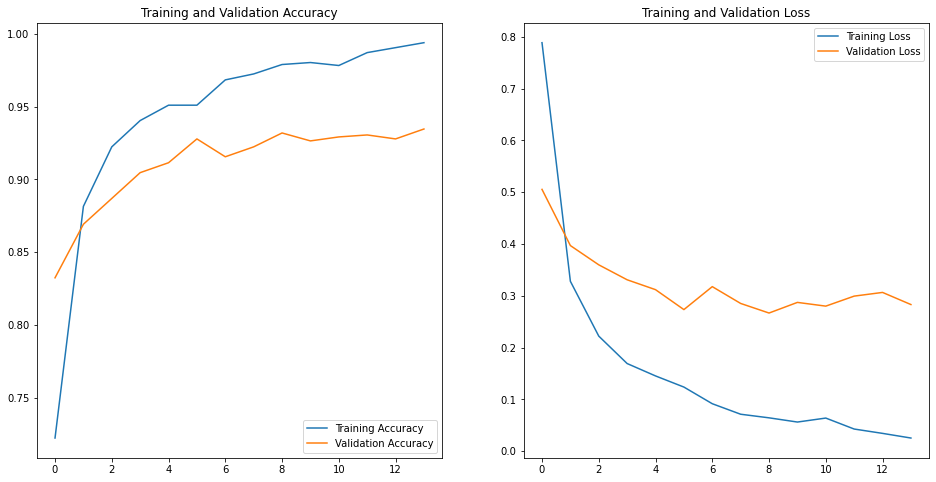

In [130]:
import matplotlib.pyplot as plt
# Traning and Validation 학습 결과 시각화
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(early_stopping.stopped_epoch+1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1) # nrows, ncols, index
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # nrows, ncols, index
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. 실제 꽃 사진 Load / Test

In [159]:
# load test flower pictures
img_dir = 'C:/JupyterProject/flowers_testset'
test_batch_size = 25
test_dataset = tf.keras.utils.image_dataset_from_directory(img_dir, labels='inferred', label_mode='categorical',
                                                           batch_size=test_batch_size, image_size=(img_height,img_width))

Found 25 files belonging to 5 classes.


In [209]:
# split(image and labels)
for images, labels in test_dataset:  # only take first element of dataset
    flower_images = images.numpy()
    flower_labels = labels.numpy()

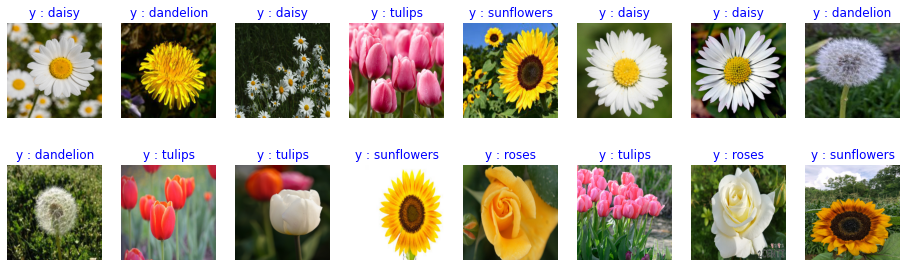

In [210]:
# Test Set Classification Visulization
np.random.seed(105)
sample_batch_size = 16
batch_index = np.random.choice(len(flower_images), size=sample_batch_size, replace=False)

batch_xs = flower_images[batch_index]
batch_ys = flower_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig3 = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
    p = fig3.add_subplot(4, 8, i+1)
    # model output으로 one-hot 변환된 y-value를 np.argmax를 통해 index값으로 재변환 한 후 비교
    if np.argmax(py) == np.argmax(batch_ys[i]): 
        p.set_title("y : {}".format(class_names[np.argmax(py)]), color='blue') # 맞춘경우 Blud
    else:
        p.set_title("y : {}".format(np.argmax(py)), color='red') # 틀린경우 Red
        
    img = np.array(px/np.amax(px)*255, np.int32) # 0~255 변환    
    p.imshow(img)
    p.axis('off') # 축표시제거